# Setup

In [1]:
import pandas as pd
import scanpy as sc
import os

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

/Users/dennisbersenev/mambaforge/envs/compbio/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.1 anndata==0.10.5 umap==0.5.5 numpy==1.24.3 scipy==1.11.1 pandas==2.2.2 scikit-learn==1.3.1 statsmodels==0.14.2 igraph==0.10.6 pynndescent==0.5.12


In [3]:
results_file = "results/pbmc3k.h5ad"  # the file that will store the analysis results

In [4]:
adata = sc.read_10x_mtx(
    "./data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

# QC

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [7]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [8]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [10]:
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [12]:
adata.raw = adata

In [13]:
adata = adata[:, adata.var.highly_variable]

In [14]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/Users/dennisbersenev/mambaforge/envs/compbio/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:01)


# Visualizing the Data Manifold

In [15]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:00)


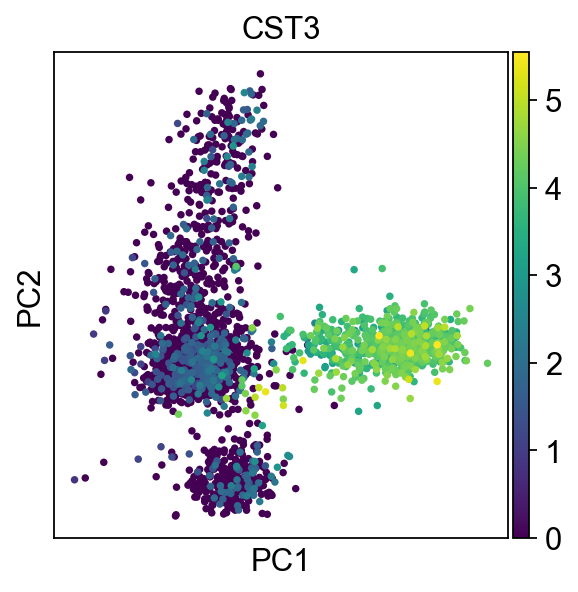

In [16]:
sc.pl.pca(adata, color="CST3")

In [17]:
adata.write(results_file)

In [18]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [19]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [20]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


# Clustering

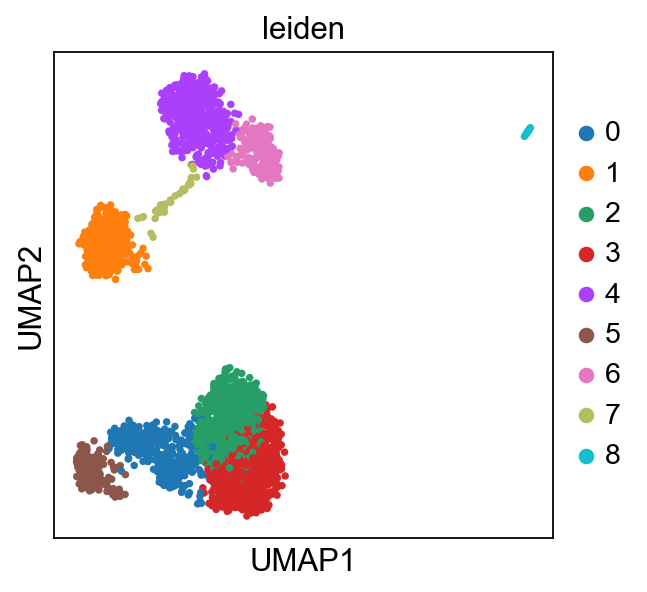

In [21]:
sc.pl.umap(adata, color=["leiden"])

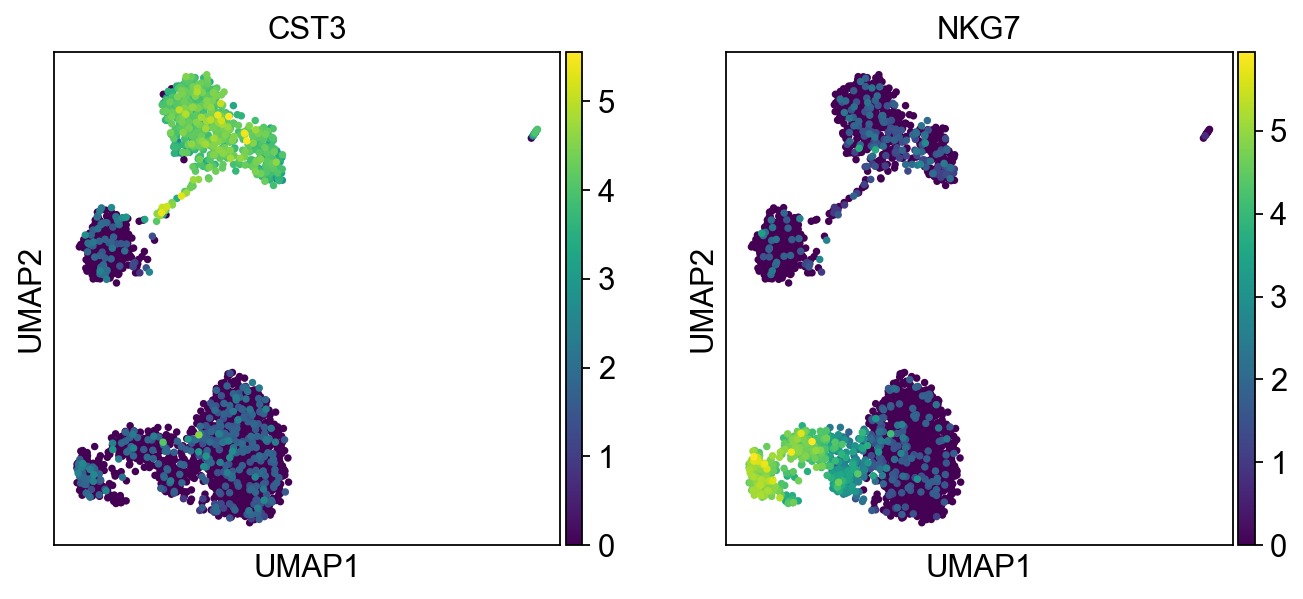

In [22]:
sc.pl.umap(adata, color=["CST3", "NKG7"])

In [23]:
adata.write(results_file)

# Finding Markers of Cell Types

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:12)


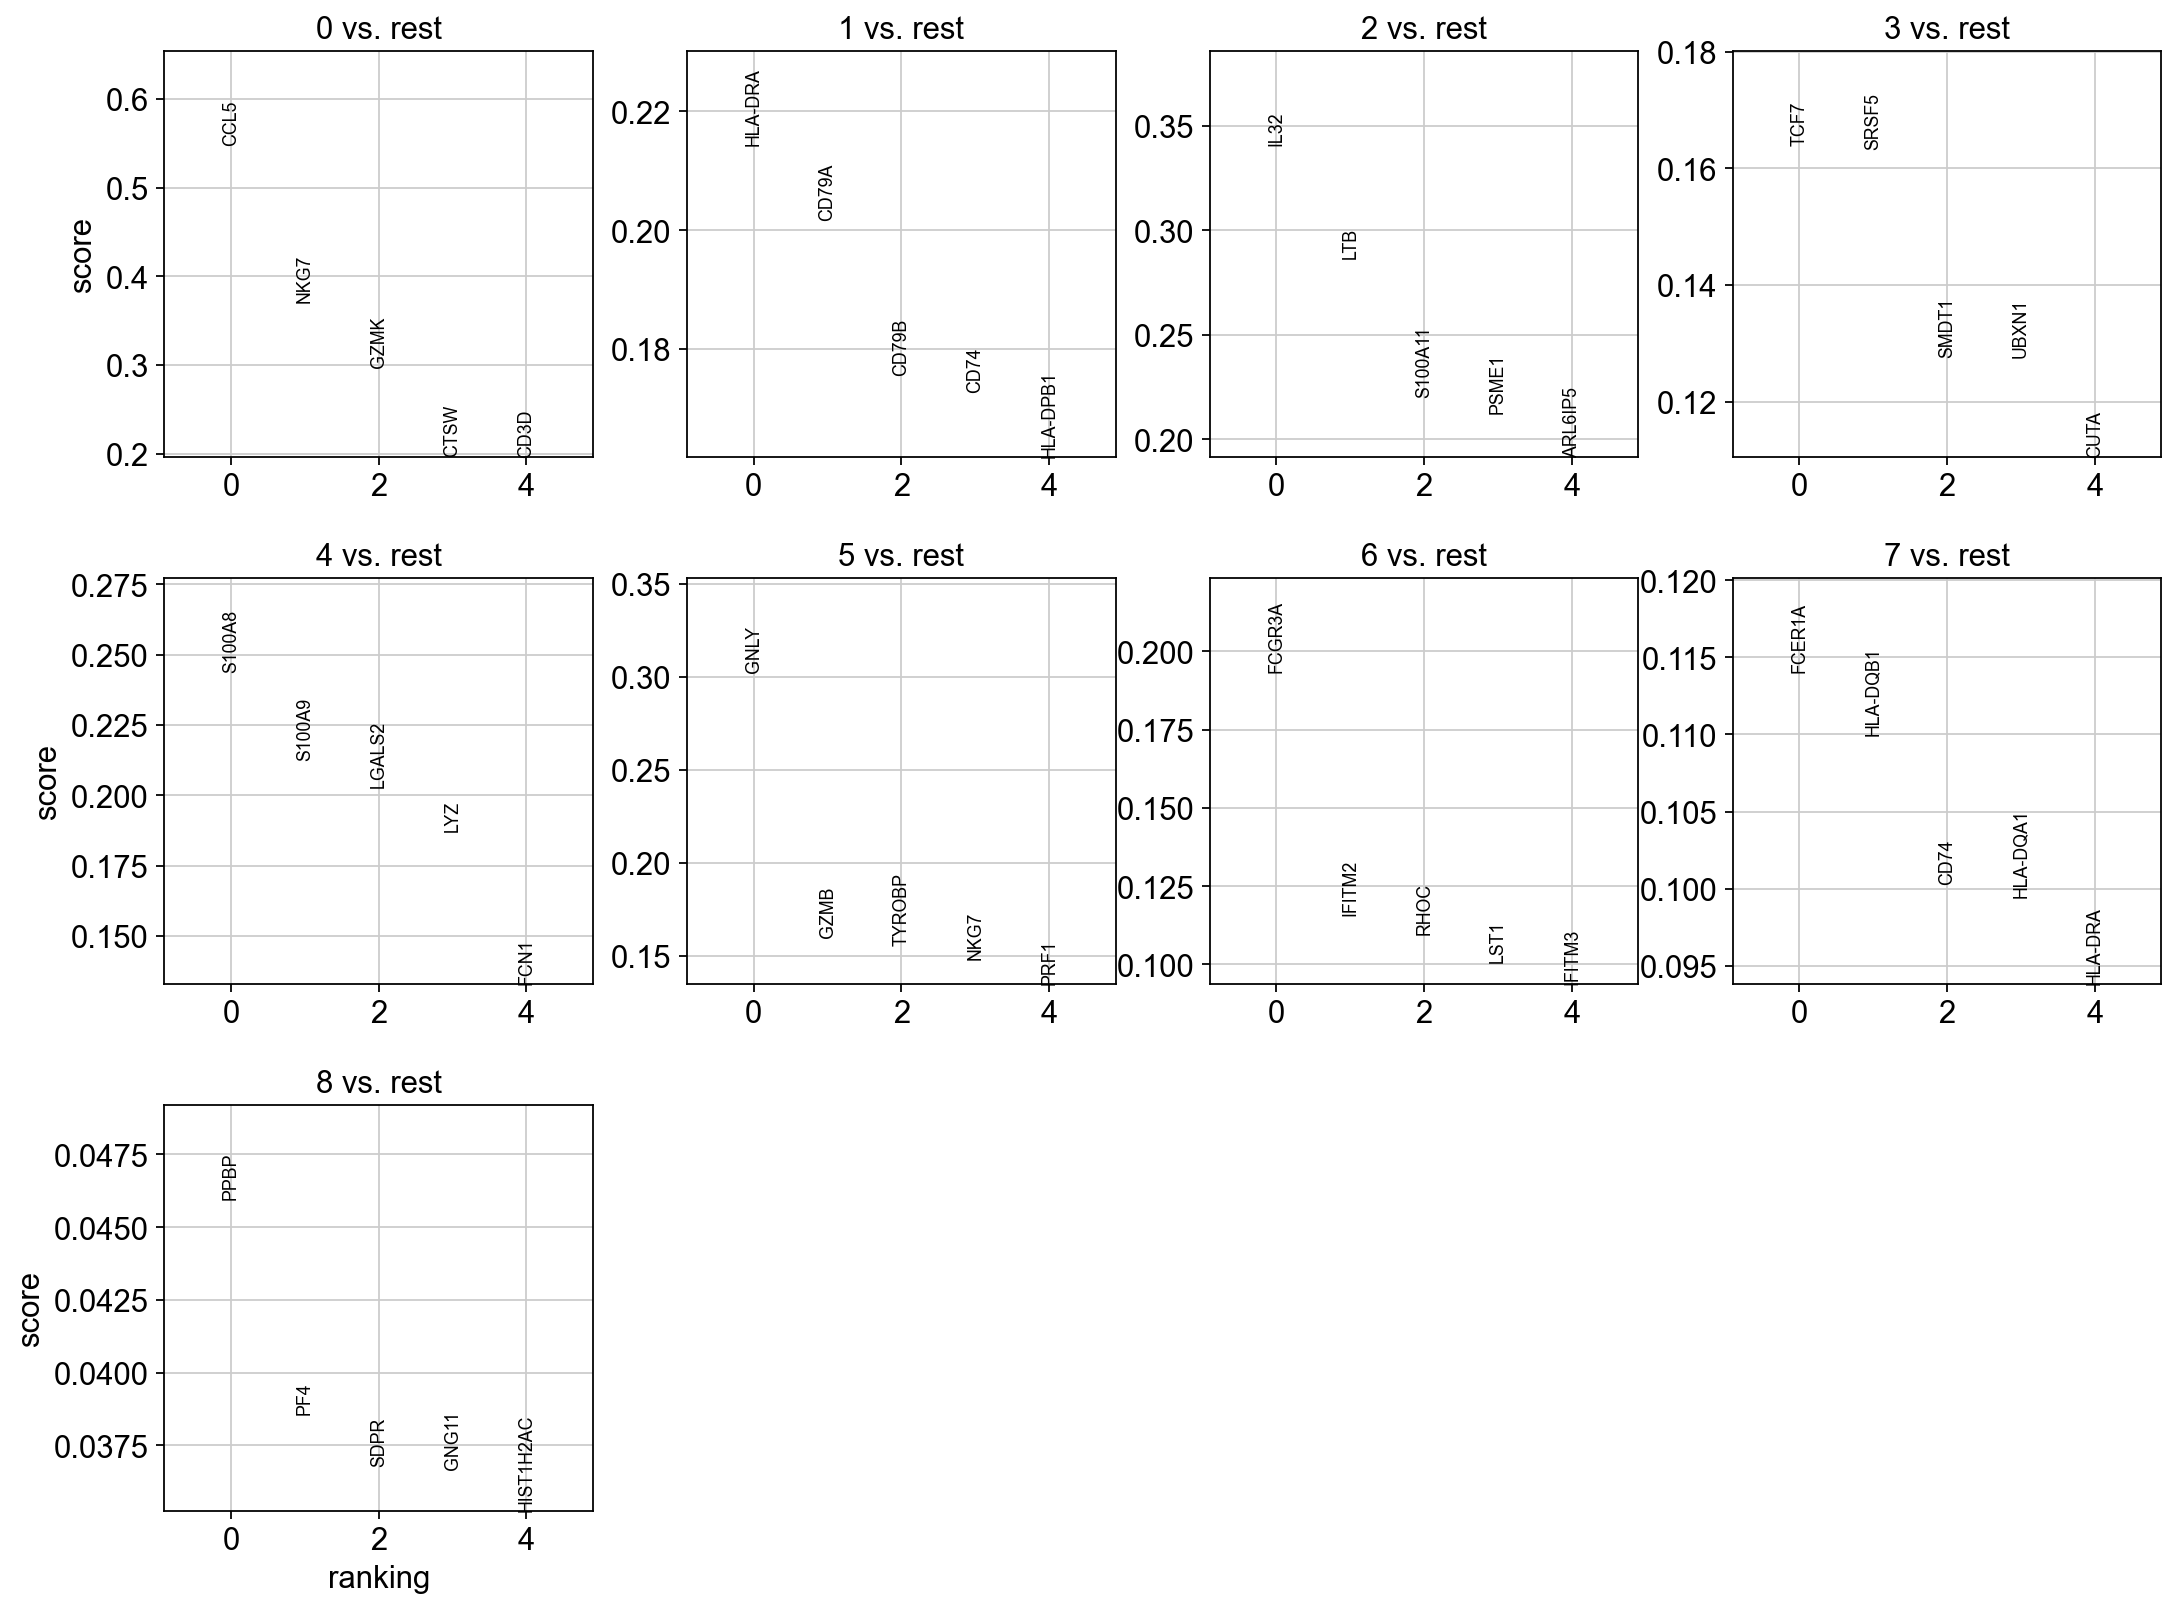

In [24]:
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)

In [25]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [26]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7,8
0,CCL5,HLA-DRA,IL32,TCF7,S100A8,GNLY,FCGR3A,FCER1A,PPBP
1,NKG7,CD79A,LTB,SRSF5,S100A9,GZMB,IFITM2,HLA-DQB1,PF4
2,GZMK,CD79B,S100A11,SMDT1,LGALS2,TYROBP,RHOC,CD74,SDPR
3,CTSW,CD74,PSME1,UBXN1,LYZ,NKG7,LST1,HLA-DQA1,GNG11
4,CD3D,HLA-DPB1,ARL6IP5,CUTA,FCN1,PRF1,IFITM3,HLA-DRA,HIST1H2AC


In [27]:
df = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])

## Utilizing LLMs
Prompt: I have a cluster of cells wherein the most prominent genes in the cluster are ranked in the text file provided. 
What cell type does this cluster likely represent?

In [28]:
dir_name = 'gene_rankings'
os.makedirs(dir_name, exist_ok=True)

In [29]:
for column_name, column_data in df.items():
    file_name = f"{dir_name}/{column_name}.txt"
    
    # Save the column data to the text file
    column_data.to_csv(file_name, index=False, header=False)

# NOTE: Could also do this next step programmatically via APIs such as LangChain, OpenAI API, etc

Query LLM of choice with contents of text files

In [30]:
# Obtained from chatGPT
new_cluster_names = [
    "CD8+",
    "B",
    "CD4+",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
    "Monocytes",
]
adata.rename_categories("leiden", new_cluster_names)

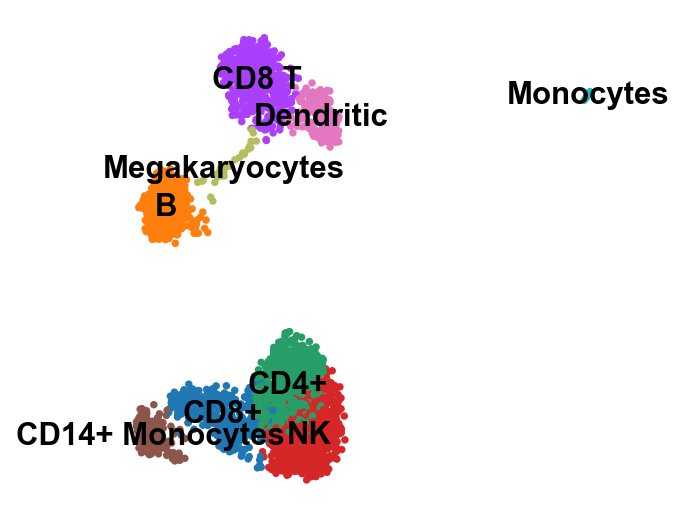

In [31]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

In [32]:
adata.raw.to_adata().write("./results/pbmc3k_withoutX.h5ad")